In [1]:
from datasets import load_dataset

ds = load_dataset("artem9k/ai-text-detection-pile")
ds

/home/ml/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})

In [2]:
import torch
torch.cuda.is_available()

True

Convert huggingface format to Pandas format

In [3]:
df = ds['train'].to_pandas()

In [4]:
df.shape

(1392522, 3)

In [5]:
df

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...
...,...,...,...
1392517,ai,1418649,"Today, I accomplished a major feat. I stepped ..."
1392518,ai,1418650,As rockets rain down from the sky\nEurope trem...
1392519,ai,1418651,"On January 6th, 2023, the world lost a true pi..."
1392520,ai,1418652,A gene bank is a repository of genetic materia...


In [6]:
# replace 'human' with 0, 'ai' with 1
df['source'] = df['source'].replace({'human': 0, 'ai': 1})
df

/tmp/ipykernel_820714/3923059119.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['source'] = df['source'].replace({'human': 0, 'ai': 1})


,source,id,text
0,0,0,12 Years a Slave: An Analysis of the Film Essa...
1,0,1,20+ Social Media Post Ideas to Radically Simpl...
2,0,2,2022 Russian Invasion of Ukraine in Global Med...
3,0,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,0,4,A Charles Schwab Corporation Case Essay\n\nCha...
...,...,...,...
1392517,1,1418649,"Today, I accomplished a major feat. I stepped ..."
1392518,1,1418650,As rockets rain down from the sky\nEurope trem...
1392519,1,1418651,"On January 6th, 2023, the world lost a true pi..."
1392520,1,1418652,A gene bank is a repository of genetic materia...


## Prepocessing

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

In [8]:
[len(train_df), len(test_df)]

[1114017, 278505]

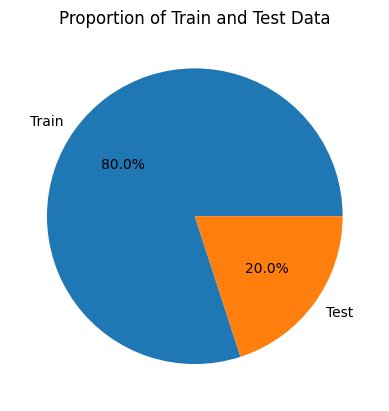

In [9]:
import matplotlib.pyplot as plt
plt.pie([len(train_df), len(test_df)], autopct='%1.1f%%', labels=['Train', 'Test'])
plt.title('Proportion of Train and Test Data')
plt.show()

### Set dataset format to tensors

In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizerFast
from datasets import Dataset

# Initialize the tokenizer
model_id = 'roberta-base'
tokenizer = RobertaTokenizerFast.from_pretrained(model_id)

# Define the tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

# Ensure your DataFrame is converted to a Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize the train and test datasets
train_encodings = train_dataset.map(tokenize, batched=True)
test_encodings = test_dataset.map(tokenize, batched=True)

2024-11-12 18:12:14.152799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731409934.215843  820714 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731409934.232742  820714 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 18:12:14.422504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
train_encodings = train_encodings.rename_column("source", "labels")
test_encodings = test_encodings.rename_column("source", "labels")

train_encodings = train_encodings.remove_columns([col for col in train_encodings.column_names if col not in ['input_ids', 'attention_mask', 'labels']])
test_encodings = test_encodings.remove_columns([col for col in test_encodings.column_names if col not in ['input_ids', 'attention_mask', 'labels']])

print(train_encodings.column_names)
print(test_encodings.column_names)

## Fine-tuning RoBERTa for text classification

In [ ]:
import torch
import evaluate
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# Load metrics using the evaluate library
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Define model and device
model = RobertaForSequenceClassification.from_pretrained(model_id, num_labels=2)

# Set device (CUDA if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Output directory for model checkpoints and results
    evaluation_strategy='epoch',  # Evaluate after every epoch
    save_strategy='epoch',  # Save model after each epoch
    learning_rate=3e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=32,  # Batch size for evaluation
    num_train_epochs=3,  # Number of training epochs
    warmup_steps=1000,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Weight decay for regularization
    logging_dir='./logs',  # Directory to store logs
    logging_steps=50,  # Log every 50 steps
    save_total_limit=3,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,  # Load the best model after training
    metric_for_best_model='accuracy',  # Metric to use for selecting the best model
    greater_is_better=True,  # Whether higher values of the metric are better
    seed=42,  # Random seed for reproducibility
    fp16=True,  # Use mixed precision training
    gradient_accumulation_steps=1,  # Number of steps to accumulate gradients
    eval_accumulation_steps=1,  # Accumulate gradients during evaluation to prevent memory issues
)

# Define your custom metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)  # Take the argmax to get the final predictions
    labels = p.label_ids

    # If preds or labels are not flat, ensure they're reshaped correctly
    if len(preds.shape) > 1:
        preds = preds.flatten()

    # Compute individual metrics
    accuracy_result = accuracy.compute(predictions=preds, references=labels)
    f1_result = f1.compute(predictions=preds, references=labels, average='binary')
    precision_result = precision.compute(predictions=preds, references=labels, average='binary')
    recall_result = recall.compute(predictions=preds, references=labels, average='binary')

    # Extract scalar values from the metric results
    result = {
        'accuracy': accuracy_result['accuracy'],  # Extract the scalar accuracy value
        'f1': f1_result['f1'],  # Extract the scalar F1 score value
        'precision': precision_result['precision'],  # Extract the scalar precision value
        'recall': recall_result['recall'],  # Extract the scalar recall value
    }

    return result


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,  # Training dataset (ensure this is preprocessed and tokenized)
    eval_dataset=test_encodings,  # Evaluation dataset (ensure this is preprocessed and tokenized)
    compute_metrics=compute_metrics  # Define the metrics computation
)

# Train the model
trainer.train()


In [ ]:
trainer.train(resume_for_checkpoint='results/checkpoint-139254')

In [ ]:
model.save_pretrained('roberta-ai-detection')
tokenizer.save_pretrained('roberta-ai-detection')